In [7]:
import os 
import random 
import torch
from torch.utils.data import Dataset
from typing import List, Optional


class ten_known_commands(Dataset):
    def __init__(
        self, base_dir, test_list_path=None, return_label_name=False, train=True,
        target_count_train=2100, target_count_test=250, silence_list=None
    ):
        self.filepaths = []
        self.labels = []
        self.return_label_name = return_label_name

        self.known_labels = [
            "no",
            "yes",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
        ]

        self.label_to_index = {
            label: idx for idx, label in enumerate(self.known_labels)
        }
        self.label_to_index["unknown"] = 10
        self.label_to_index["silence"] = 11
        self.index_to_label = {idx: label for label, idx in self.label_to_index.items()}

        included_files = set()

        # Load filenames from testing_list.txt if provided
        if test_list_path and os.path.exists(test_list_path):
            with open(test_list_path, "r") as f:
                for line in f:
                    file_name = os.path.splitext(os.path.basename(line.strip()))[0] + ".pt"
                    included_files.add(file_name)

        all_folders = os.listdir(base_dir)

        # Temporary storages
        unknown_samples = []

        for label in all_folders:
            label_path = os.path.join(base_dir, label)

            if not os.path.isdir(label_path):
                continue

            if label == "silence":
                continue  # Silence is handled separately!

            if label in self.known_labels:
                assigned_label = label
            else:
                assigned_label = "unknown"

            for file in os.listdir(label_path):
                if file.endswith(".pt"):
                    file_base = os.path.splitext(file)[0] + ".pt"
                    is_included = file_base in included_files

                    if (train and not is_included) or (not train and is_included):
                        if assigned_label == "unknown":
                            unknown_samples.append(os.path.join(label_path, file))
                        else:
                            self.filepaths.append(os.path.join(label_path, file))
                            self.labels.append(self.label_to_index[assigned_label])

        # Handle unknown undersampling
        if train:
            if unknown_samples:
                undersampled_unknown = random.sample(unknown_samples, k=target_count_train)
                self.filepaths.extend(undersampled_unknown)
                self.labels.extend([self.label_to_index["unknown"]] * target_count_train)
        else:
            if unknown_samples:
                undersampled_unknown = random.sample(unknown_samples, k=target_count_test)
                self.filepaths.extend(undersampled_unknown)
                self.labels.extend([self.label_to_index["unknown"]] * target_count_test)

        # Handle silence separately
        
        if silence_list is not None:
            if train:
                print("train")
                oversampled_silence = random.choices(silence_list, k=target_count_train)
                self.filepaths.extend(oversampled_silence)
                self.labels.extend([self.label_to_index["silence"]] * target_count_train)
            else:
                print("test")
                oversampled_silence = random.choices(silence_list, k=target_count_test)
                self.filepaths.extend(oversampled_silence)
                self.labels.extend([self.label_to_index["silence"]] * target_count_test)

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        spectrogram = torch.load(self.filepaths[idx])
        label_index = self.labels[idx]
        return spectrogram, (
            self.index_to_label[label_index] if self.return_label_name else label_index
        )


In [8]:
import os
import random
import torch
from torch.utils.data import DataLoader



def pad_collate(batch):
    specs, labels = zip(*batch)
    max_len = max(spec.shape[-1] for spec in specs)
    padded_specs = []

    for spec in specs:
        pad_len = max_len - spec.shape[-1]
        padded_spec = torch.nn.functional.pad(spec, (0, pad_len), value=0)
        padded_specs.append(padded_spec)

    return torch.stack(padded_specs), torch.tensor(labels)


base_path = "../data/processed/train/audio"
test_list_path = "../data/raw/train/testing_list.txt"

# Prepare silence train/test splits
import os
import random

silence_dir = "../data/processed/train/audio/silence"
all_silence_files = [
    os.path.join(silence_dir, file)
    for file in os.listdir(silence_dir)
    if file.endswith(".pt")
]

random.seed(42)  
random.shuffle(all_silence_files)
split_idx = int(0.9 * len(all_silence_files))
train_silence_files = all_silence_files[:split_idx]
test_silence_files = all_silence_files[split_idx:]


train_dataset = ten_known_commands(
    base_path,
    test_list_path=test_list_path,
    return_label_name=False,
    train=True,
    silence_list=train_silence_files,
)
test_dataset = ten_known_commands(
    base_path,
    test_list_path=test_list_path,
    return_label_name=False,
    train=False,
    silence_list=test_silence_files,
)

train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True, collate_fn=pad_collate
)
test_loader = DataLoader(
    test_dataset, batch_size=16, shuffle=False, collate_fn=pad_collate
)

train
test


In [9]:
import torch 
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))


from models import CNNRNNWithAttention


model_path_three_classes_classifier = "../mlruns/133062935170151282/5814591e959d438c84280243e46cdba3/artifacts/checkpoints/model_epoch_14.pth"

model_3_classes = CNNRNNWithAttention(
    num_classes=3, input_freq_bins=128
)
model_3_classes.load_state_dict(torch.load(model_path_three_classes_classifier))


from models import CNNRNNClassifierDropout
import torch
import matplotlib.pyplot as plt

model_path = "../mlruns/994349557920624102/ee6ba8f825ef47c6bdf7998a555f68a7/artifacts/checkpoints/model_epoch_22.pth"
model_10_classes = CNNRNNClassifierDropout(num_classes=10, input_freq_bins=128)


model_10_classes.load_state_dict(torch.load(model_path))
model_10_classes.eval()

C:\Users\cypri\AppData\Local\Temp\ipykernel_23092\1615296475.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_3_classes.load_state_dict(torch.load(model_path_three

CNNRNNClassifierDropout(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.2, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.2, inplace=False)
  )
  (rnn): GRU(2048, 128, batch_first=True, bidirectional=True)
  (dropout_rnn_out): Dropout(p=0.3, inplace=False)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  

C:\Users\cypri\AppData\Local\Temp\ipykernel_23092\4173280733.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(self.filepaths[idx])


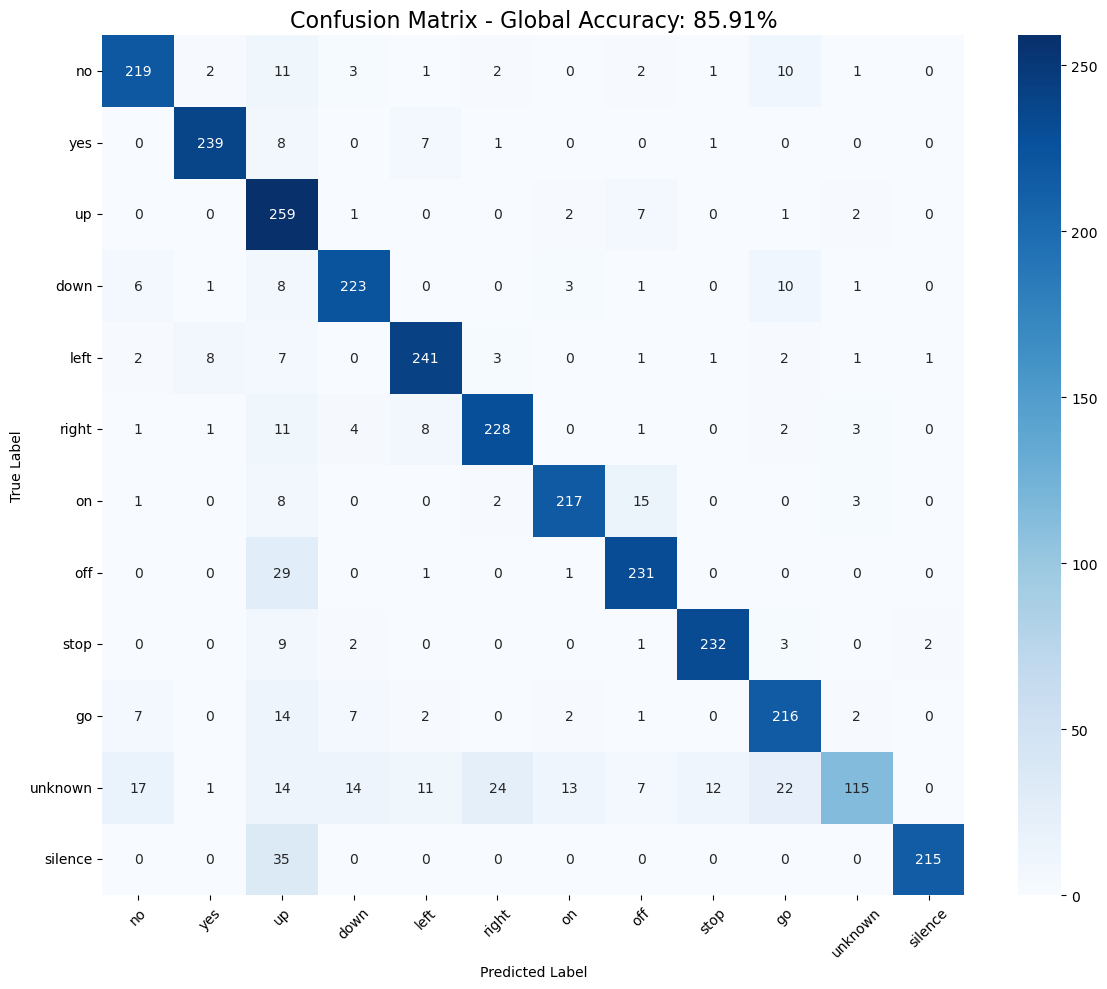

In [11]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class names
final_class_names = [
    "no",
    "yes",
    "up",
    "down",
    "left",
    "right",
    "on",
    "off",
    "stop",
    "go",
    "unknown",
    "silence",
]

# Prepare to store
all_preds_final = []
all_labels_final = []

# Set models to evaluation mode
model_3_classes.eval()
model_10_classes.eval()

for X, y in test_loader:
    X, y = X.to(device), y.to(device)

    with torch.no_grad():
        # Step 1: 3-classes prediction
        out_3_classes = model_3_classes(X)
        preds_3_classes = out_3_classes.argmax(dim=1)

        # Step 2: Initialize batch-level final predictions
        preds_final_batch = []

        for i in range(X.size(0)):
            pred_3 = preds_3_classes[i].item()
            true_label = y[i].item()

            if pred_3 == 0:  # 0 -> known
                # Use 10-classes model
                x_known = X[i].unsqueeze(0)  # Add batch dimension
                out_10_classes = model_10_classes(x_known)
                pred_10 = out_10_classes.argmax(dim=1).item()
                preds_final_batch.append(
                    pred_10
                )  # 0-9 map directly to final_class_names
            elif pred_3 == 1:  # 1 -> unknown
                preds_final_batch.append(10)  # index 10 -> unknown
            else:  # 2 -> silence
                preds_final_batch.append(11)  # index 11 -> silence

            # True label mapping
            if true_label <= 9:
                all_labels_final.append(true_label)  # known classes
            elif true_label == 10:
                all_labels_final.append(10)  # unknown
            else:
                all_labels_final.append(11)  # silence

        all_preds_final.extend(preds_final_batch)

# Compute confusion matrix
conf_mat = confusion_matrix(all_labels_final, all_preds_final, labels=list(range(12)))

# Compute global accuracy
global_acc = accuracy_score(all_labels_final, all_preds_final)

# --- BEAUTIFUL PLOTTING ---
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=final_class_names,
    yticklabels=final_class_names,
    cbar=True,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - Global Accuracy: {global_acc*100:.2f}%", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()